## Environment Setup

In [ ]:
%pip install -q pyreadstat gdown xgboost shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 10.7 MB/s eta 0:00:00


In [ ]:
%pip install -U gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [ ]:
%pip install -q ydata_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.3 MB/s eta 0:00:00


In [ ]:
%pip install distfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
from distfit import distfit
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import scipy.stats as stats

import xgboost as xgb
import os
import pickle

## Data Downloading

In [ ]:
import gdown
# All
gdown.download(id="1S8agHpzNckOElaGqRU7byP40tPIznxXW")
# Zinc, Copper
gdown.download(id="1ausKJoiSEUVg1hxTumwQAeAMfgAZrRou")

Downloading...
From: https://drive.google.com/uc?id=1S8agHpzNckOElaGqRU7byP40tPIznxXW
To: /content/HTN_NEW.sav
100%|██████████| 1.79M/1.79M [00:00<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ausKJoiSEUVg1hxTumwQAeAMfgAZrRou
To: /content/HTN_zink.sav
100%|██████████| 346k/346k [00:00<00:00, 88.1MB/s]


'HTN_zink.sav'

In [ ]:
df_raw = pd.read_spss("./HTN_NEW.sav").drop(["HTN_2_1"], axis=1)
df_raw.head()

,File.No,HTN_phase2,HTN_phase1,phase1,Glocuse,LdL,Cholesterol,HDL,Triglycerides,Diabete,...,MPV,bunincerate,uriaid_HDL,Uricacid_bunincerate,Sex,age_1,AnxietyScore,DepressionScore,smokingstutus,BMI
0,3048.0,NaN,NaN,phase1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,male,35.0,NaN,NaN,non smoker,NaN
1,3321.0,NaN,NaN,phase1,87.0,110.3,175.0,37.9,134.0,<126,...,10.6,NaN,0.160950,NaN,male,48.0,NaN,NaN,non smoker,NaN
2,3855.0,NaN,NaN,phase1,125.0,91.8,174.0,25.0,286.0,>=126,...,9.7,NaN,0.208000,NaN,male,55.0,49.0,38.0,current smoker,26.948463
3,4044.0,NaN,NaN,phase1,74.0,234.0,315.0,52.9,167.0,<126,...,10.9,NaN,0.077505,NaN,female,37.0,5.0,2.0,non smoker,27.226562
4,6002.0,NaN,NaN,phase1,92.0,118.6,195.0,38.0,112.0,NaN,...,9.8,13.0,0.134211,0.392308,female,56.0,8.0,14.0,non smoker,25.654874


In [ ]:
df_zink = pd.read_spss("./HTN_zink.sav")
df_zink.head()

,FileNo,Copper,Zinc,Zinc_Copper,copper_zinc
0,125.0,161.0,70.8,0.439752,2.274011
1,160.0,103.0,80.3,0.779612,1.282690
2,176.0,151.0,79.7,0.527815,1.894605
3,178.0,151.0,127.0,0.841060,1.188976
4,184.0,149.0,NaN,NaN,NaN


In [ ]:
df_raw.dtypes, df_zink.dtypes

(File.No                  float64
 HTN_phase2              category
 HTN_phase1              category
 phase1                  category
 Glocuse                  float64
 LdL                     category
 Cholesterol              float64
 HDL                      float64
 Triglycerides            float64
 Diabete                 category
 hs_CRP                   float64
 Uricacid                 float64
 WBC                      float64
 RBC                      float64
 HGB                      float64
 HCT                      float64
 MCV                      float64
 MCH                      float64
 PLT                      float64
 LYM                      float64
 NEUT                     float64
 RDW                      float64
 PDW                      float64
 MPV                      float64
 bunincerate              float64
 uriaid_HDL               float64
 Uricacid_bunincerate     float64
 Sex                     category
 age_1                    float64
 AnxietyScore 

In [ ]:
df_zink = df_zink.set_index('FileNo')

In [ ]:
df = df_raw.join(df_zink, on="File.No", how="left")
df

,File.No,HTN_phase2,HTN_phase1,phase1,Glocuse,LdL,Cholesterol,HDL,Triglycerides,Diabete,...,Sex,age_1,AnxietyScore,DepressionScore,smokingstutus,BMI,Copper,Zinc,Zinc_Copper,copper_zinc
0,3048.0,NaN,NaN,phase1,NaN,NaN,NaN,NaN,NaN,NaN,...,male,35.0,NaN,NaN,non smoker,NaN,NaN,76.6,NaN,NaN
1,3321.0,NaN,NaN,phase1,87.0,110.3,175.0,37.9,134.0,<126,...,male,48.0,NaN,NaN,non smoker,NaN,61.0,136.6,2.239344,0.446559
2,3855.0,NaN,NaN,phase1,125.0,91.8,174.0,25.0,286.0,>=126,...,male,55.0,49.0,38.0,current smoker,26.948463,137.0,64.5,0.470803,2.124031
3,4044.0,NaN,NaN,phase1,74.0,234.0,315.0,52.9,167.0,<126,...,female,37.0,5.0,2.0,non smoker,27.226562,126.0,64.5,0.511905,1.953488
4,6002.0,NaN,NaN,phase1,92.0,118.6,195.0,38.0,112.0,NaN,...,female,56.0,8.0,14.0,non smoker,25.654874,145.0,72.5,0.500000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9699,18846.0,yes,HTN+,phase1,314.0,95.2,178.0,49.6,166.0,>=126,...,male,58.0,9.0,19.0,non smoker,32.141732,28.0,68.1,2.432143,0.411160
9700,18855.0,yes,HTN+,phase1,102.0,147.7,241.0,63.7,148.0,<126,...,female,44.0,0.0,7.0,non smoker,27.038936,88.0,74.0,0.840909,1.189189
9701,18858.0,yes,HTN+,phase1,80.0,107.6,190.0,67.2,76.0,<126,...,female,52.0,4.0,10.0,non smoker,23.749482,87.0,93.0,1.068966,0.935484
9702,18864.0,yes,HTN+,phase1,314.0,147.0,262.0,50.4,420.0,>=126,...,female,55.0,29.0,28.0,current smoker,31.169029,77.0,69.1,0.897403,1.114327


In [ ]:
df['File.No'].value_counts()

File.No
2012.0     2
2586.0     2
4137.0     1
4061.0     1
4036.0     1
          ..
3687.0     1
3692.0     1
3697.0     1
3705.0     1
18866.0    1
Name: count, Length: 9704, dtype: int64

In [ ]:
# Remove duplicated indecies
df = df.drop(index=df.index[df['File.No'] == 2586])
df = df.drop(index=df.index[df['File.No'] == 2012])

## Preprocessing

In [ ]:
df.shape

(9702, 37)

In [ ]:
renaming_mapper = {
    'HTN_phase1': 'HTN_2_1',
}
df = df.rename(columns=renaming_mapper)

In [ ]:
df.HTN_2_1.value_counts()

HTN_2_1
HTN-    6638
HTN+    3035
Name: count, dtype: int64

In [ ]:
df.smokingstutus.value_counts()

smokingstutus
non smoker        6653
current smoker    2092
Ex-smoker          957
Name: count, dtype: int64

In [ ]:
df.Diabete.value_counts()

Diabete
<126     8194
>=126    1368
Name: count, dtype: int64

In [ ]:
def show(df_):
    print(f"ratio: {round(df_.shape[0] / df.shape[0] * 100,1)}%")
    return df_.head(3)

In [ ]:
def map_diabete(x):
    match x:
        case "<126":
            return 0.0
        case ">=126":
            return 1.0
        case _:
            return x;

def map_sex(x):
    match x:
        case "male":
            return 0.0
        case "female":
            return 1.0
        case _:
            # print(f"some thing wrong {x=}") ???????? only 2
            return x


target_names = ["HTN-", "HTN+"]


def map_htn(x):
    if x == target_names[0]:
        return 0.0
    if x == target_names[1]:
        return 1.0
    return x


df.Diabete = df.Diabete.apply(map_diabete)
df.Sex = df.Sex.apply(map_sex)
df.HTN_2_1 = df.HTN_2_1.apply(map_htn)

In [ ]:
df = df.drop(["HTN_phase2", "File.No", 'phase1'], axis=1)

In [ ]:
# Encode Categorical
oneHotEncoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encodedSmokingStatus = oneHotEncoder.fit_transform(df[['smokingstutus']])
encodedSmokingStatusDF = pd.DataFrame(encodedSmokingStatus, columns=oneHotEncoder.get_feature_names_out())

df = pd.concat([df, encodedSmokingStatusDF], axis=1)

In [ ]:
df = df.drop(['smokingstutus'], axis=1)

In [ ]:
n_na = df.apply(
    lambda x: np.where(x[1:].isna())[0].shape[0], axis=1
)
n_na.describe(percentiles=[0.75, 0.9, 0.93, 0.95])

count    9704.000000
mean        1.314819
std         2.616417
min         0.000000
50%         0.000000
75%         2.000000
90%         3.000000
93%         4.000000
95%         5.000000
max        32.000000
dtype: float64

In [ ]:
df

,HTN_2_1,Glocuse,LdL,Cholesterol,HDL,Triglycerides,Diabete,hs_CRP,Uricacid,WBC,...,AnxietyScore,DepressionScore,BMI,Copper,Zinc,Zinc_Copper,copper_zinc,smokingstutus_Ex-smoker,smokingstutus_current smoker,smokingstutus_non smoker
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,76.6,NaN,NaN,0.0,0.0,1.0
1,NaN,87.0,110.3,175.0,37.9,134.0,0.0,1.36,6.1,6.9,...,NaN,NaN,NaN,61.0,136.6,2.239344,0.446559,0.0,0.0,1.0
2,NaN,125.0,91.8,174.0,25.0,286.0,1.0,3.50,5.2,10.4,...,49.0,38.0,26.948463,137.0,64.5,0.470803,2.124031,0.0,1.0,0.0
3,NaN,74.0,234.0,315.0,52.9,167.0,0.0,3.03,4.1,9.0,...,5.0,2.0,27.226562,126.0,64.5,0.511905,1.953488,0.0,0.0,1.0
4,NaN,92.0,118.6,195.0,38.0,112.0,NaN,9.80,5.1,2.5,...,8.0,14.0,25.654874,145.0,72.5,0.500000,2.000000,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9701,1.0,80.0,107.6,190.0,67.2,76.0,0.0,1.30,3.9,3.7,...,4.0,10.0,23.749482,87.0,93.0,1.068966,0.935484,0.0,0.0,1.0
9702,1.0,314.0,147.0,262.0,50.4,420.0,1.0,4.60,4.5,5.7,...,29.0,28.0,31.169029,77.0,69.1,0.897403,1.114327,NaN,NaN,NaN
9703,1.0,101.0,100.9,175.0,53.5,103.0,0.0,0.40,4.7,6.2,...,8.0,10.0,24.161736,176.0,70.0,0.397727,2.514286,NaN,NaN,NaN
266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0


In [ ]:
renaming_mapper = {
    'MLP': 'MLR',
    'MPP': 'MPR',
    'LYM_Sh': 'LYM',
    'NEUT_Sh': 'NEUT',
    'hs_CRP': 'hsCRP',
    'age_1': 'age'
}
df = df.rename(columns=renaming_mapper)

In [ ]:
df_pure = df[n_na <= 3]
df_pure[~df_pure.HTN_2_1.isna()].shape[0], df[~df.HTN_2_1.isna()].shape[0]

(8944, 9673)

In [ ]:
y_ = df_pure.HTN_2_1
X_ = df_pure.drop(["HTN_2_1"], axis=1)

In [ ]:
columns = X_.columns
without_sex_columns = columns.drop(['Sex'])

In [ ]:
percentile_df = X_.describe(percentiles=[.01,.99]).transpose()
percentile_df

,count,mean,std,min,1%,50%,99%,max
Glocuse,8966.0,92.705699,39.051668,31.000000,56.000000,83.000000,276.700000,429.000000
Cholesterol,8966.0,191.610027,39.342775,73.000000,112.000000,188.000000,302.000000,433.000000
HDL,8966.0,42.841265,9.904425,12.800000,24.465000,41.800000,71.000000,96.200000
Triglycerides,8966.0,142.729166,92.436105,22.000000,41.000000,120.000000,475.000000,1225.000000
hsCRP,8962.0,4.245378,9.010716,0.000000,0.350000,1.650000,53.074600,104.500000
Uricacid,8965.0,4.666586,1.403927,0.000000,2.000000,4.500000,8.300000,31.700000
WBC,8965.0,6.085865,1.566374,0.000000,3.300000,5.900000,10.700000,34.600000
RBC,8966.0,4.854107,0.483393,0.590000,3.880000,4.820000,6.113500,7.980000
HGB,8966.0,13.740773,1.747535,0.000000,9.400000,13.700000,17.000000,92.000000
HCT,8966.0,41.236248,3.905487,19.000000,31.500000,41.200000,49.900000,92.500000


In [ ]:
X_.shape, y_.shape

((8966, 35), (8966,))

In [ ]:
# Remove records that have `hsCRP` above 10
hsCRP_filter = X_[X_['hsCRP'] > 10].index
X_ = X_.drop(hsCRP_filter, axis=0)
y_ = y_.drop(hsCRP_filter, axis=0)
df_pure = df_pure.drop(hsCRP_filter, axis=0)

In [ ]:
for c in percentile_df.index:
  one_pecent = percentile_df.loc[c]['1%']
  ninty_precent = percentile_df.loc[c]['99%']

  if (c == 'hsCRP'):
    # Ignore the upper ninty percent part of the hsCRP since we removed them already
    filter = (X_[c] < one_pecent)
  else:
    filter = (X_[c] < one_pecent) | (X_[c] > ninty_precent)

  X_.loc[filter, c] = np.nan

In [ ]:
cat_columns_names = ['Diabete', 'Sex', 'smokingstutus_Ex-smoker', 'smokingstutus_current smoker', 'smokingstutus_non smoker']
cat_columns_count = len(cat_columns_names)
cat_columns_indices = [X_.columns.get_loc(c) for c in cat_columns_names]
cat_columns_indices

[5, 23, 32, 33, 34]

In [ ]:
non_cat_columns_indices = [i for i in range(0, len(X_.columns)) if i not in cat_columns_indices]

# Change the order of columns
cat_columns = X_.columns[cat_columns_indices]
non_cat_columns = X_.columns[non_cat_columns_indices]

columns = [*non_cat_columns.tolist(), *cat_columns.tolist()]

X_ = X_[columns]
X_

,Glocuse,LdL,Cholesterol,HDL,Triglycerides,hsCRP,Uricacid,WBC,RBC,HGB,...,BMI,Copper,Zinc,Zinc_Copper,copper_zinc,Diabete,Sex,smokingstutus_Ex-smoker,smokingstutus_current smoker,smokingstutus_non smoker
2,125.0,91.8,174.0,25.0,286.0,3.50,5.2,10.4,NaN,16.1,...,26.948463,137.0,64.5,0.470803,2.124031,1.0,0.0,0.0,1.0,0.0
3,74.0,234.0,NaN,52.9,167.0,3.03,4.1,9.0,4.43,13.7,...,27.226562,126.0,64.5,0.511905,1.953488,0.0,1.0,0.0,0.0,1.0
4,92.0,118.6,195.0,38.0,112.0,9.80,5.1,NaN,4.76,12.0,...,25.654874,145.0,72.5,0.500000,2.000000,NaN,1.0,0.0,0.0,1.0
5,85.0,102.109091,170.0,43.8,53.0,1.30,5.9,4.3,4.78,13.8,...,24.194841,92.0,70.4,0.765217,1.306818,0.0,0.0,0.0,0.0,1.0
6,88.0,112.3,183.0,37.9,164.0,2.99,4.7,5.9,4.86,11.9,...,35.174227,97.0,97.8,1.008247,0.991820,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9697,82.0,137.6,209.0,43.6,139.0,1.30,5.9,5.5,5.13,14.4,...,29.752744,63.0,78.6,1.247619,0.801527,0.0,0.0,0.0,0.0,1.0
9698,102.0,213.0,277.0,53.5,181.0,1.20,6.2,5.4,4.76,12.8,...,30.014274,61.0,72.7,1.191803,0.839065,1.0,1.0,0.0,0.0,1.0
9699,NaN,95.2,178.0,49.6,166.0,6.20,6.7,6.7,5.03,13.6,...,32.141732,28.0,68.1,2.432143,0.411160,1.0,0.0,0.0,0.0,1.0
9700,102.0,147.7,241.0,63.7,148.0,0.90,5.2,5.3,NaN,NaN,...,27.038936,88.0,74.0,0.840909,1.189189,0.0,1.0,0.0,1.0,0.0


In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_, y_, test_size=0.1, random_state=42
)

In [ ]:
# KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights="distance")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Round values since they're categorical
X_train[:, -5:] = np.round(X_train[:,  -5:])
X_test[:, -5:] = np.round(X_test[:, -5:])

In [ ]:
# Remove NA Targets

train_na_idx = y_train.isna()
X_train = X_train[~train_na_idx]
y_train = y_train[~train_na_idx]

test_na_idx = y_test.isna()
X_test = X_test[~test_na_idx]
y_test = y_test[~test_na_idx]

In [ ]:
Xy = [np.concatenate((X_train, y_train.to_numpy().reshape(-1,1)), axis=1),
np.concatenate((X_test, y_test.to_numpy().reshape(-1,1)), axis=1)]

Xy = np.concatenate(Xy, axis=0)

## Analysis

In [ ]:
df = pd.DataFrame(Xy, columns=[*columns, "HTN_2_1"])
# df

In [ ]:
df=df.drop(["Zinc_Copper", "copper_zinc"], axis=1)

In [ ]:
columns.remove("Zinc_Copper")
columns.remove("copper_zinc")

In [ ]:
# filter = (df.BMI >=18.5) & (df.BMI <25)
filter = df["smokingstutus_non smoker"] == 1
len(df[(df.HTN_2_1==1) & filter]) / len(df[filter]) * 100


31.074350764852365

In [ ]:
def smokingstutus(x):
  if x["smokingstutus_Ex-smoker"]==1:
    return 0.0#"ex-smoker"
  if x["smokingstutus_current smoker"]==1:
    return 1.0#"smoker"
  if x["smokingstutus_non smoker"]==1:
    return 2.0#"non-smoker"

df["smokingstutus"] = df.apply(smokingstutus, axis=1)

In [ ]:
for c in df.columns:
  # ad_p_value = sm.stats.diagnostic.normal_ad(df[c])[1]
  # ad_p_value = sm.stats.diagnostic.lilliefors(df[c], dist='norm', pvalmethod='approx')[0]
  ad_p_value = sm.stats.stattools.jarque_bera(df[c], axis=0)[0]
  unique_count = df[c].unique().shape[0]

  if ad_p_value>0.05 and unique_count>4:
    #Normal
    print("Normal", c)
  elif unique_count>4:
    #Abnormal
    print("Abnormal", c)
  else:
    #categorical
    print("categorical", c)

Normal Glocuse
Normal LdL
Normal Cholesterol
Normal HDL
Normal Triglycerides
Normal hsCRP
Normal Uricacid
Normal WBC
Normal RBC
Normal HGB
Normal HCT
Normal MCV
Normal MCH
Normal PLT
Normal LYM
Normal NEUT
Normal RDW
Normal PDW
Normal MPV
Normal bunincerate
Normal uriaid_HDL
Normal Uricacid_bunincerate
Normal age
Normal AnxietyScore
Normal DepressionScore
Normal BMI
Normal Copper
Normal Zinc
categorical Diabete
categorical Sex
categorical smokingstutus_Ex-smoker
categorical smokingstutus_current smoker
categorical smokingstutus_non smoker
categorical HTN_2_1
categorical smokingstutus


In [ ]:
data = []
for c in df.columns:
  def foo(x):
    return round(x, 5)

  ad_p_value = foo(sm.stats.diagnostic.normal_ad(df[c])[1])
  k_p_value = foo(sm.stats.diagnostic.kstest_normal(df[c], dist='norm', pvalmethod='approx')[1])
  jarque_p_value = foo(sm.stats.stattools.jarque_bera(df[c], axis=0)[1])
  shapiro_p_value = foo(sp.stats.shapiro(df[c])[1])
  data.append([c,k_p_value,shapiro_p_value,jarque_p_value, ad_p_value])

pd.DataFrame(data, columns=[
    "column name",
    "Kolmogorov-Smirnov",
    "Shapiro–Wilk",
    "Jarque-Bera",
    "Anderson-Darling ",
])

,column name,Kolmogorov-Smirnov,Shapiro–Wilk,Jarque-Bera,Anderson-Darling
0,Glocuse,0.0000,0.0,0.0,0.00000
1,LdL,0.0000,0.0,0.0,0.00000
2,Cholesterol,0.0000,0.0,0.0,0.00000
3,HDL,0.0000,0.0,0.0,0.00000
4,Triglycerides,0.0000,0.0,0.0,0.00000
5,hsCRP,0.0000,0.0,0.0,0.00000
6,Uricacid,0.0000,0.0,0.0,0.00000
7,WBC,0.0000,0.0,0.0,0.00000
8,RBC,0.0000,0.0,0.0,0.00000
9,HGB,0.0000,0.0,0.0,0.00000


In [ ]:
D={}
for c in tqdm(df.columns):
  dfit = distfit(distr='popular',verbose=0)
  dfit.fit_transform(df[c].to_numpy())
  D[c] = dfit.summary["name"][0]


100%|██████████| 35/35 [01:15<00:00,  2.16s/it]


In [ ]:
np.unique(list(D.values()))

array(['beta', 'dweibull', 'expon', 'gamma', 'genextreme', 'lognorm',
       'norm', 'pareto', 't'], dtype='<U10')

In [ ]:
def plot_hist(filter_dist):
  n=len([None for d in D.values() if d == filter_dist])
  fig, axs = plt.subplots(nrows=1,figsize=(4*n,5), ncols=n)
  i=0
  A=[]
  for c, d in D.items():
    if d == filter_dist:
      if n>1:
        ax = axs[i]
      else:
        ax = axs
      df[c].hist(bins=80, ax=ax)
      ax.set_title(c)
      i+=1
      A.append(c)
  fig.show()
  print(*A)

RBC MPV uriaid_HDL age AnxietyScore


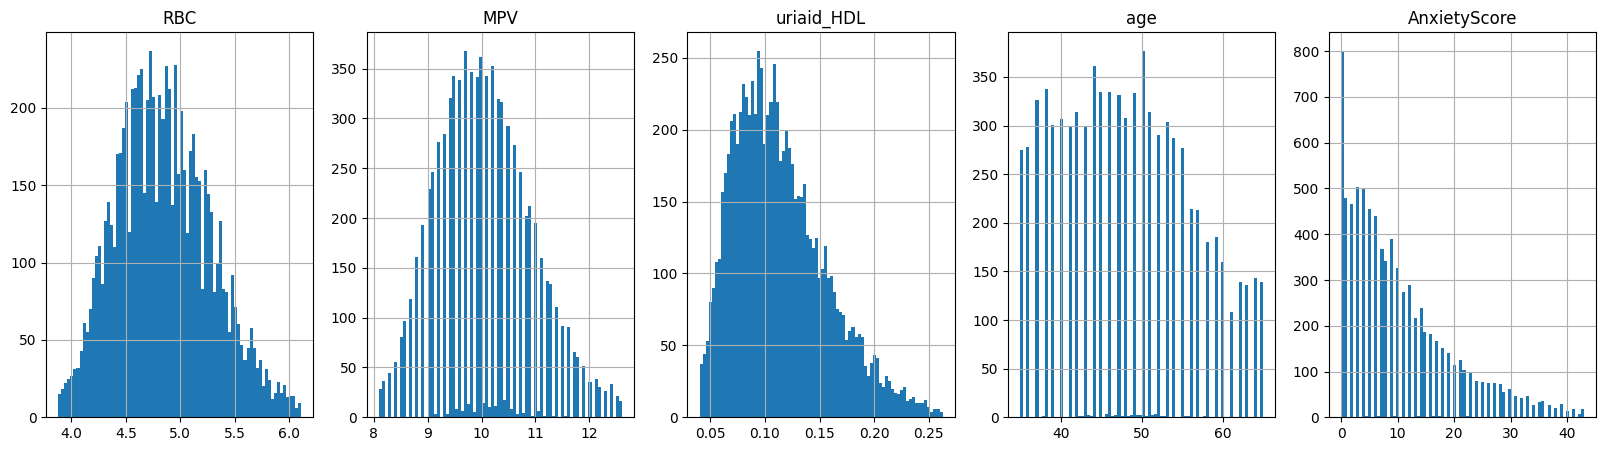

In [ ]:
plot_hist("beta")

HGB MCH bunincerate


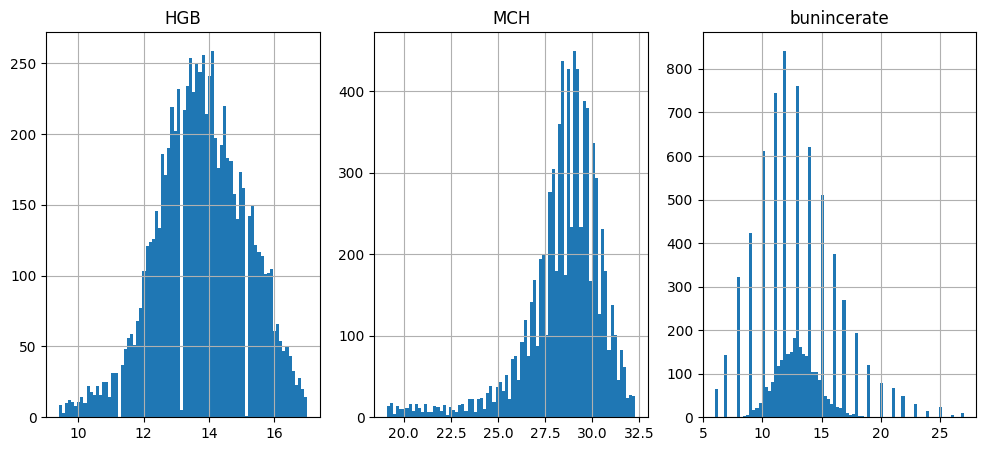

In [ ]:
plot_hist("dweibull")

Diabete smokingstutus_Ex-smoker


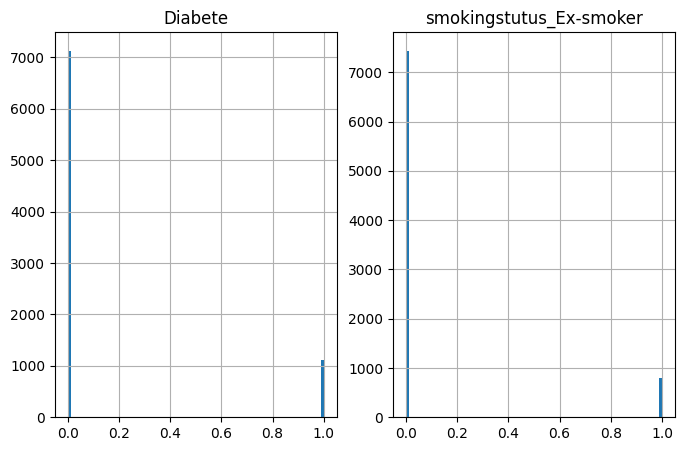

In [ ]:
plot_hist("expon")

HDL Triglycerides Uricacid WBC PDW DepressionScore smokingstutus_current smoker


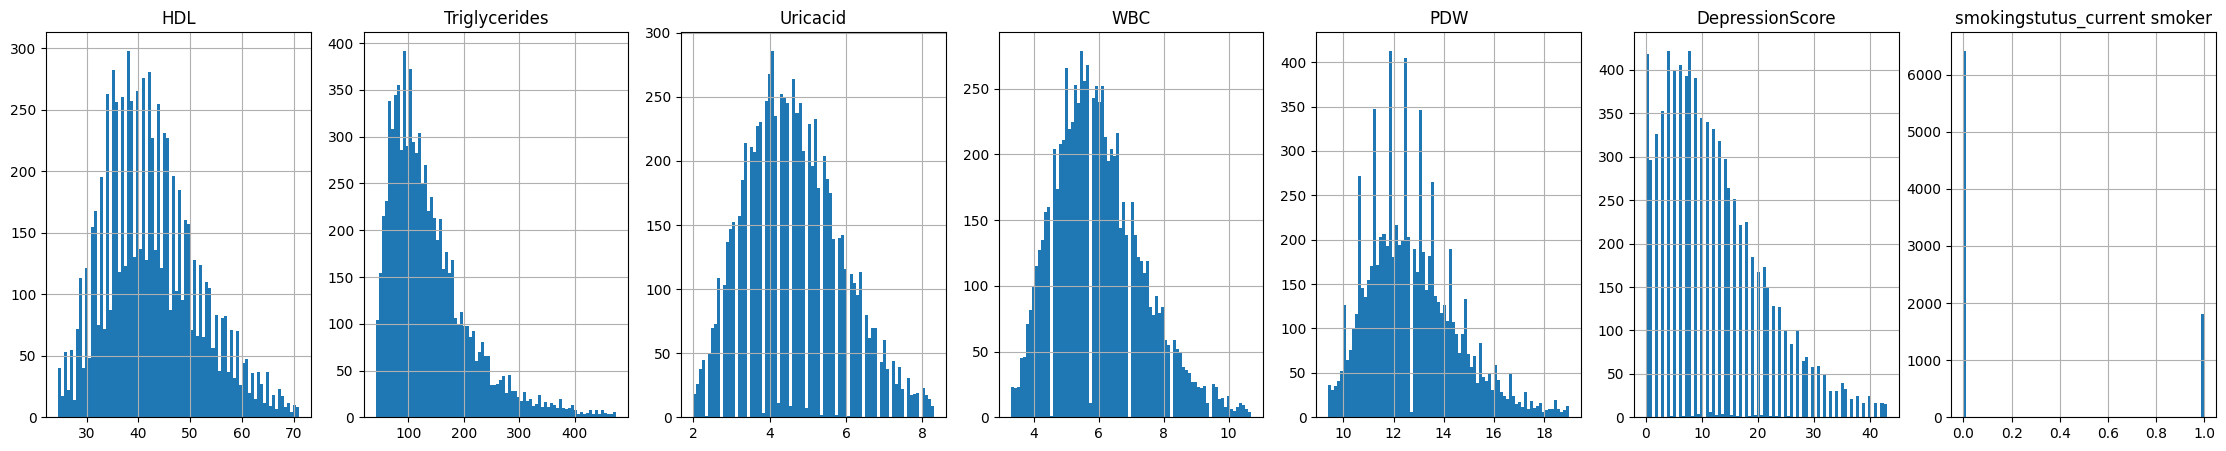

In [ ]:
plot_hist("gamma")

Glocuse Cholesterol HCT LYM NEUT Zinc Sex smokingstutus_non smoker smokingstutus


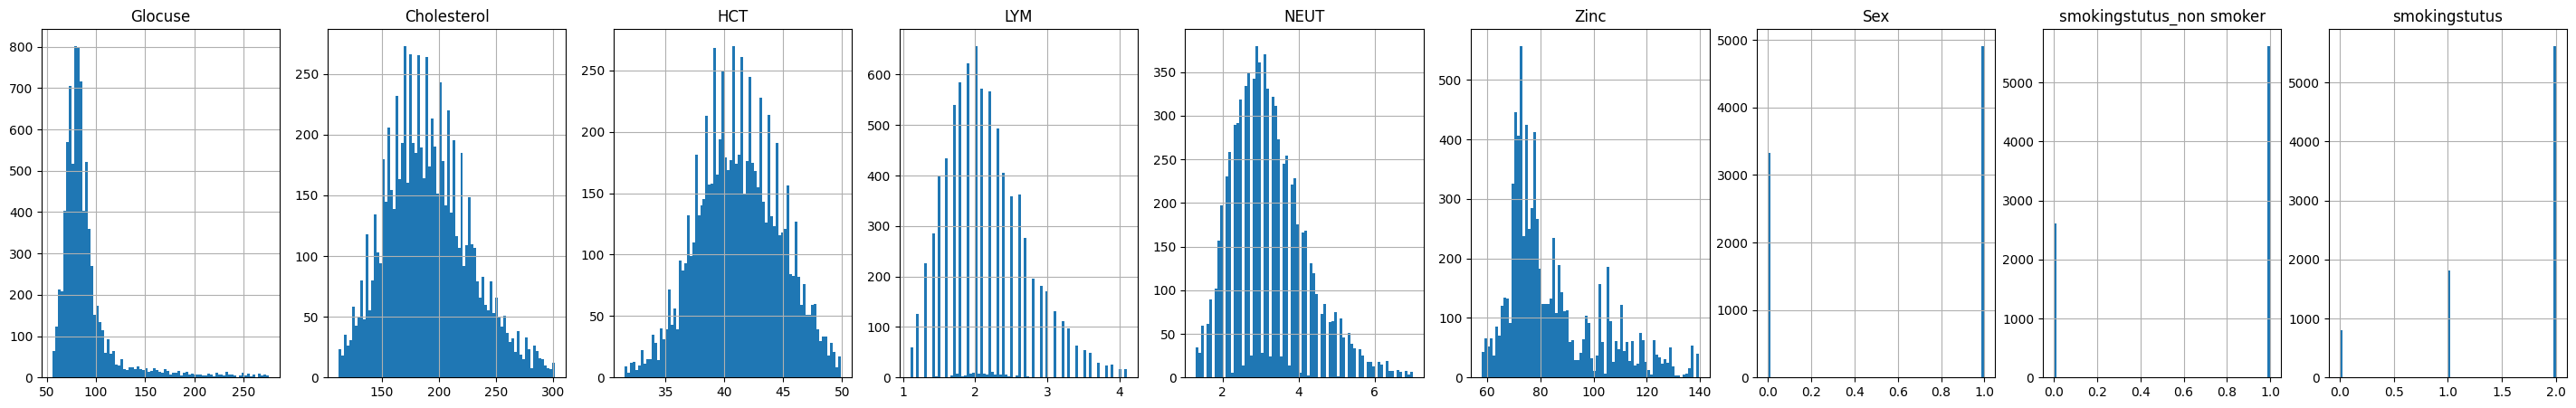

In [ ]:
plot_hist("genextreme")

hsCRP PLT BMI Copper


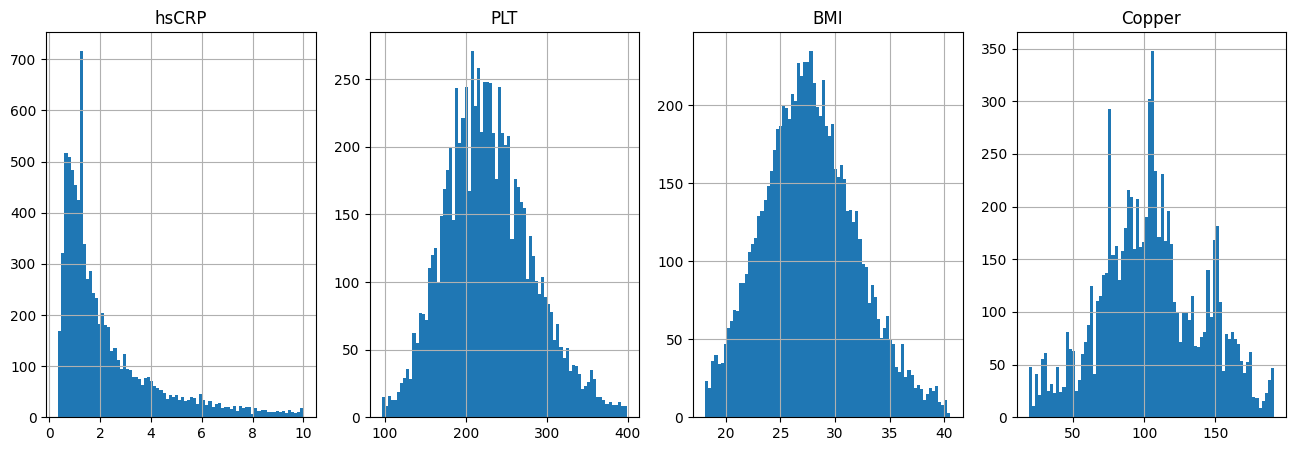

In [ ]:
plot_hist("lognorm")

RDW


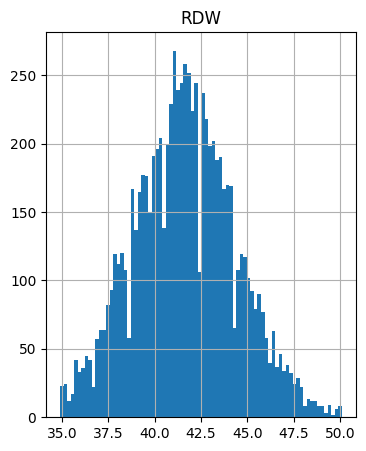

In [ ]:
plot_hist("norm")

HTN_2_1


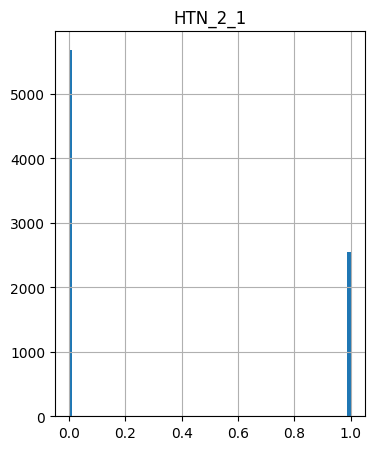

In [ ]:
plot_hist("pareto")

LdL MCV Uricacid_bunincerate


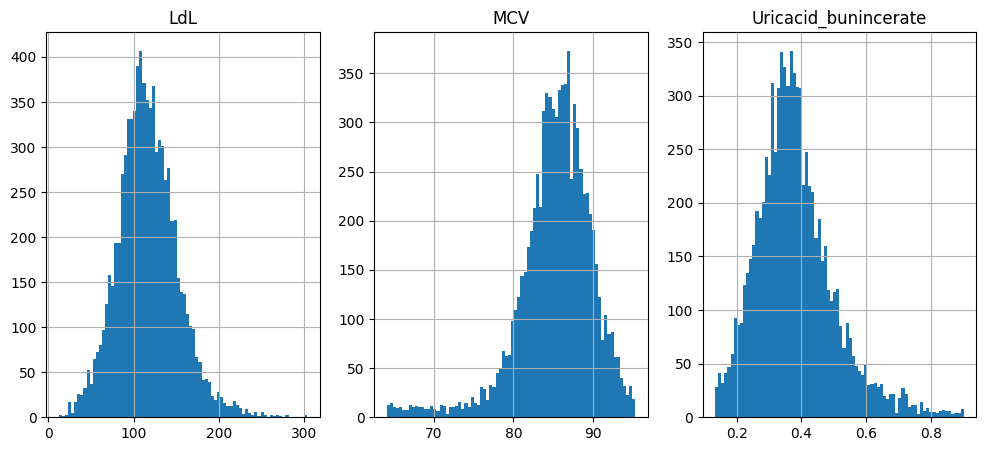

In [ ]:
plot_hist("t")

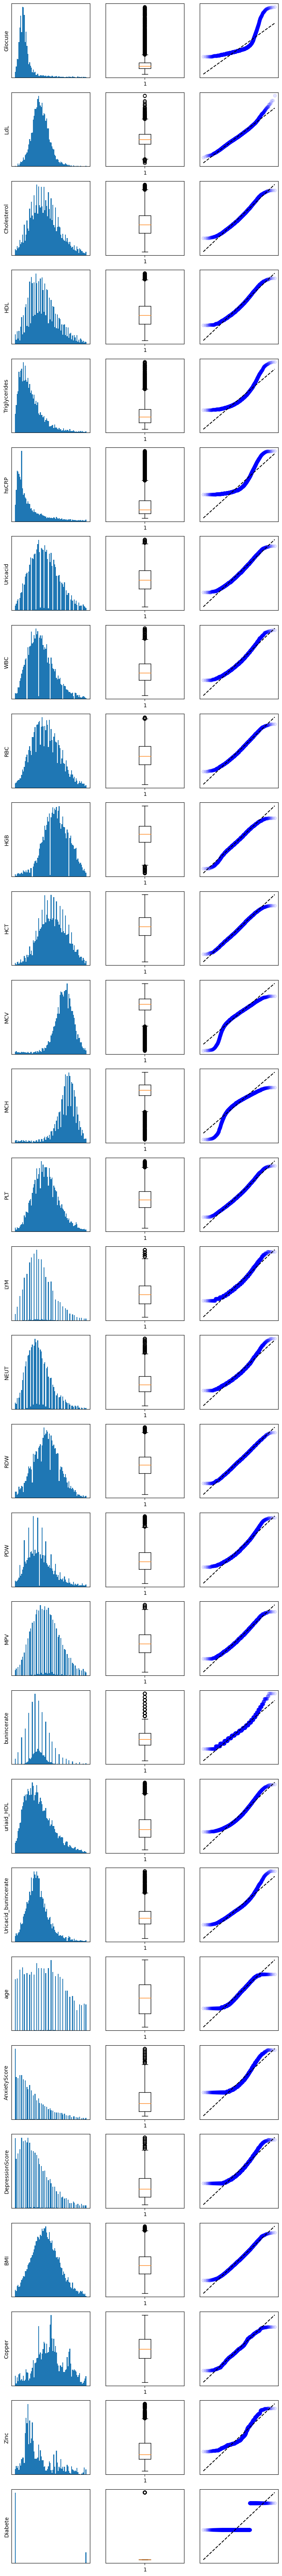

In [ ]:
non_cat_cols = df.columns[:-6]

a=3
fig, axs = plt.subplots(len(non_cat_cols), 3, figsize=(3*a, len(non_cat_cols)*a))

for i, c in enumerate(non_cat_cols):
  axs[i,0].set_xticks([])
  axs[i,0].set_yticks([])
  axs[i,1].set_xticks([])
  axs[i,1].set_yticks([])
  axs[i,2].set_xticks([])
  axs[i,2].set_yticks([])

  axs[i,0].set_ylabel(c)

  x = df[c].to_numpy()
  axs[i,0].hist(x, 80, density=True)
  axs[i,1].boxplot(x)

  data_sorted = np.sort(x)
  mu = np.mean(data_sorted)
  std = np.std(data_sorted)
  data_sorted = (data_sorted-mu) / std
  reference_sorted = np.sort(np.random.normal(loc=0, scale=1, size=len(data_sorted)))
  percentiles = np.linspace(0, 100, len(data_sorted))
  theoretical_quantiles = stats.norm.ppf(percentiles / 100.0)
  axs[i,2].scatter(theoretical_quantiles, data_sorted, color='blue', alpha=0.1)
  axs[i,2].plot(theoretical_quantiles, theoretical_quantiles, color='black', linestyle='--')

In [ ]:
#dict([(c,"abnormal") for c in df.columns])
dist_of_data = {
    'Glocuse': 'abnormal',
    'LdL': 'normal',
    'Cholesterol': 'normal',
    'HDL': 'abnormal',
    'Triglycerides': 'abnormal',
    'hsCRP': 'abnormal',
    'Uricacid': 'normal',
    'WBC': 'abnormal',
    'RBC': 'normal',
    'HGB': 'abnormal',
    'HCT': 'normal',
    'MCV': 'abnormal',
    'MCH': 'abnormal',
    'PLT': 'normal',
    'LYM': 'abnormal',
    'NEUT': 'abnormal',
    'RDW': 'normal',
    'PDW': 'abnormal',
    'MPV': 'normal',
    'bunincerate': 'abnormal',
    'uriaid_HDL': 'abnormal',
    'Uricacid_bunincerate': 'abnormal',
    'age': 'abnormal',
    'AnxietyScore': 'abnormal',
    'DepressionScore': 'abnormal',
    'BMI': 'normal',
    'Copper': 'abnormal',
    'Zinc': 'abnormal',
    'Diabete': 'categorical',
    'Sex': 'categorical',
    'smokingstutus': 'categorical',
    # 'smokingstutus_Ex-smoker': 'categorical',
    # 'smokingstutus_current smoker': 'categorical',
    # 'smokingstutus_non smoker': 'categorical',
 }

In [ ]:
def normal_metrics(df,c,grp=""):
  htn_pos = df["HTN_2_1"] == 1
  if grp != "":
    grp = f"{grp}_"
  return {
    f"total_{grp}mean":df[c].mean(),
    f"total_{grp}std":df[c].std(),
    f"htn_neg_{grp}mean":df[~htn_pos][c].mean(),
    f"htn_neg_{grp}std":df[~htn_pos][c].std(),
    f"htn_pos_{grp}mean":df[htn_pos][c].mean(),
    f"htn_pos_{grp}std":df[htn_pos][c].std(),
    f"total_{grp}pvalue":
      sm.stats.ttest_ind(
        df[~htn_pos][c],
        df[htn_pos][c], alternative='two-sided',
        usevar='pooled',
        value=0)[1]
  }

def abnormal_metrics(df,c,grp=""):
  htn_pos = df["HTN_2_1"] == 1
  if grp != "":
    grp = f"{grp}_"
  return {
    f"total_{grp}q1":df[c].quantile(0.25),
    f"total_{grp}q2":df[c].quantile(0.50),
    f"total_{grp}q3":df[c].quantile(0.75),
    f"htn_neg_{grp}q1":df[~htn_pos][c].quantile(0.25),
    f"htn_neg_{grp}q2":df[~htn_pos][c].quantile(0.50),
    f"htn_neg_{grp}q3":df[~htn_pos][c].quantile(0.75),
    f"htn_pos_{grp}q1":df[htn_pos][c].quantile(0.25),
    f"htn_pos_{grp}q2":df[htn_pos][c].quantile(0.50),
    f"htn_pos_{grp}q3":df[htn_pos][c].quantile(0.75),
    f"total_{grp}pvalue":
      sp.stats.mannwhitneyu(
        df[~htn_pos][c],
        df[htn_pos][c]
        )[1]
  }

def categorical_metrics(df,c,grp=""):
  htn_pos = df["HTN_2_1"] == 1
  if grp != "":
    grp = f"{grp}_"

  res = {}
  lows = []
  highs = []

  for cat in df[c].unique():
    _df = df
    count = len(_df[_df[c]==cat])
    res[f"total_{grp}{cat}"] = count
    res[f"total_{grp}{cat}_percent"] = count / len(_df)

  for cat in df[c].unique():
    _df = df[~htn_pos]
    count = len(_df[_df[c]==cat])
    lows.append(count)
    res[f"htn_neg_{grp}{cat}"] =  count
    res[f"htn_neg_{grp}{cat}_percent"] = count / len(_df)

  for cat in df[c].unique():
    _df = df[htn_pos]
    count = len(_df[_df[c]==cat])
    highs.append(count)
    res[f"htn_pos_{grp}{cat}"] = count
    res[f"htn_pos_{grp}{cat}_percent"] = count / len(_df)

  contingency = np.asarray([lows,highs])
  res[f"total_{grp}pvalue"] = sp.stats.chi2_contingency(contingency).pvalue

  return res

In [ ]:
def merge_normalـ(m, grp=""):
  if grp != "":
    _grp = f"_{grp}"
    grp_ = f"{grp}_"
  else:
    _grp = ""
    grp_ = ""

  pval = m[f"total_{grp_}pvalue"]

  return {
      f"total{_grp}":f"{m[f'total_{grp_}mean']:.2f} ± {m[f'total_{grp_}std']:.2f}",
      f"htn_neg{_grp}":f"{m[f'htn_neg_{grp_}mean']:.2f} ± {m[f'htn_neg_{grp_}std']:.2f}",
      f"htn_pos{_grp}":f"{m[f'htn_pos_{grp_}mean']:.2f} ± {m[f'htn_pos_{grp_}std']:.2f}",
      f"pvalue{_grp}" : f"{pval:.3f}" if pval>=0.001 else "<0.001"
  }

def merge_abnormalـ(m, grp=""):
  if grp != "":
    _grp = f"_{grp}"
    grp_ = f"{grp}_"
  else:
    _grp = ""
    grp_ = ""

  pval = m[f"total_{grp_}pvalue"]

  return {
      f"total{_grp}":f"{m[f'total_{grp_}q2']:.2f} ({m[f'total_{grp_}q1']:.2f}, {m[f'total_{grp_}q3']:.2f})",
      f"htn_neg{_grp}":f"{m[f'htn_pos_{grp_}q2']:.2f} ({m[f'htn_pos_{grp_}q1']:.2f}, {m[f'htn_pos_{grp_}q3']:.2f})",
      f"htn_pos{_grp}":f"{m[f'htn_neg_{grp_}q2']:.2f} ({m[f'htn_neg_{grp_}q1']:.2f}, {m[f'htn_neg_{grp_}q3']:.2f})",
      f"pvalue{_grp}" : f"{pval:.3f}" if pval>=0.001 else "<0.001"
  }

def merge_catـ(m, grp=""):
  if grp != "":
    _grp = f"_{grp}"
    grp_ = f"{grp}_"
  else:
    _grp = ""
    grp_ = ""

  pval = m.get(f"total_{grp_}pvalue")

  try:
    m[f'total_{grp_}2.0_percent']
    return {
        f"total{_grp}":f"{m.get(f'total_{grp_}0.0')} ({m.get(f'total_{grp_}0.0_percent',0)*100:.2f}%)\n{m.get(f'total_{grp_}1.0')} ({m.get(f'total_{grp_}1.0_percent',0)*100:.2f}%)\n{m.get(f'total_{grp_}2.0')} ({m.get(f'total_{grp_}2.0_percent',0)*100:.2f}%)",
        f"htn_neg{_grp}":f"{m.get(f'htn_neg_{grp_}0.0')} ({m.get(f'htn_neg_{grp_}0.0_percent',0)*100:.2f}%)\n{m.get(f'htn_neg_{grp_}1.0')} ({m.get(f'htn_neg_{grp_}1.0_percent',0)*100:.2f}%)\n{m.get(f'htn_neg_{grp_}2.0')} ({m.get(f'htn_neg_{grp_}2.0_percent',0)*100:.2f}%)",
        f"htn_pos{_grp}":f"{m.get(f'htn_pos_{grp_}0.0')} ({m.get(f'htn_pos_{grp_}0.0_percent',0)*100:.2f}%)\n{m.get(f'htn_pos_{grp_}1.0')} ({m.get(f'htn_pos_{grp_}1.0_percent',0)*100:.2f}%)\n{m.get(f'htn_pos_{grp_}2.0')} ({m.get(f'htn_pos_{grp_}2.0_percent',0)*100:.2f}%)",
        f"pvalue{_grp}" : f"{pval:.3f}" if pval>=0.001 else "<0.001"
    }
  except:
    return {
        f"total{_grp}":f"{m.get(f'total_{grp_}0.0')} ({m.get(f'total_{grp_}0.0_percent',0)*100:.2f}%)\n{m.get(f'total_{grp_}1.0')} ({m.get(f'total_{grp_}1.0_percent',0)*100:.2f}%)",
        f"htn_neg{_grp}":f"{m.get(f'htn_neg_{grp_}0.0')} ({m.get(f'htn_neg_{grp_}0.0_percent',0)*100:.2f}%)\n{m.get(f'htn_neg_{grp_}1.0')} ({m.get(f'htn_neg_{grp_}1.0_percent',0)*100:.2f}%)",
        f"htn_pos{_grp}":f"{m.get(f'htn_pos_{grp_}0.0')} ({m.get(f'htn_pos_{grp_}0.0_percent',0)*100:.2f}%)\n{m.get(f'htn_pos_{grp_}1.0')} ({m.get(f'htn_pos_{grp_}1.0_percent',0)*100:.2f}%)",
        f"pvalue{_grp}" : f"{pval:.3f}" if pval>=0.001 else "<0.001"
    }


def merge_cat(m):
  return merge_catـ(m, grp="") | merge_catـ(m, grp="male") | merge_catـ(m, grp="female")

def merge_normal(m):
  return merge_normalـ(m, grp="") | merge_normalـ(m, grp="male") | merge_normalـ(m, grp="female")

def merge_abnormal(m):
  return merge_abnormalـ(m, grp="") | merge_abnormalـ(m, grp="male") | merge_abnormalـ(m, grp="female")

In [ ]:
idx_normal = [c for c, d in dist_of_data.items() if d == "normal"]
male_female = [normal_metrics(df,c) for c, d in dist_of_data.items() if d == "normal"]
male = [normal_metrics(df[df.Sex==0],c,"male") for c, d in dist_of_data.items() if d == "normal"]
female = [normal_metrics(df[df.Sex==1],c,"female") for c, d in dist_of_data.items() if d == "normal"]
all_normal = [ merge_normal(a|b|c) for a,b,c in zip(male_female,male,female)]

In [ ]:
idx_abnormal  = [c for c, d in dist_of_data.items() if d == "abnormal"]
male_female = [abnormal_metrics(df,c) for c, d in dist_of_data.items() if d == "abnormal"]
male = [abnormal_metrics(df[df.Sex==0],c,"male") for c, d in dist_of_data.items() if d == "abnormal"]
female = [abnormal_metrics(df[df.Sex==1],c,"female") for c, d in dist_of_data.items() if d == "abnormal"]
all_abnormal = [ merge_abnormal(a|b|c) for a,b,c in zip(male_female,male,female)]

In [ ]:
idx_cat = [c for c, d in dist_of_data.items() if d == "categorical"]
male_female = [categorical_metrics(df,c) for c, d in dist_of_data.items() if d == "categorical"]
male = [categorical_metrics(df[df.Sex==0],c,"male") for c, d in dist_of_data.items() if d == "categorical"]
female = [categorical_metrics(df[df.Sex==1],c,"female") for c, d in dist_of_data.items() if d == "categorical"]
all_cat = [ merge_cat(a|b|c) for a,b,c in zip(male_female,male,female)]

In [ ]:
htn_pos = df["HTN_2_1"] == 1
male = df["Sex"] == 0
count = {
  "total": len(df),
  "htn_neg": len(df[~htn_pos]),
  "htn_pos":len(df[htn_pos]),
  "pvalue":None,
  "total_male": len(df[male]),
  "htn_neg_male": len(df[male & ~htn_pos]),
  "htn_pos_male": len(df[male & htn_pos]),
  "pvalue":None,
  "total_female": len(df[~male]),
  "htn_neg_female":  len(df[~male & ~htn_pos]),
  "htn_pos_female": len(df[~male & htn_pos]),
  "pvalue":None,
}

In [ ]:
t1 = pd.DataFrame([count, *all_abnormal,*all_normal,*all_cat],
             index=["Count", *idx_abnormal, *idx_normal,*idx_cat]
             )

In [ ]:
t1

,total,htn_neg,htn_pos,pvalue,total_male,htn_neg_male,htn_pos_male,total_female,htn_neg_female,htn_pos_female,pvalue_male,pvalue_female
Count,8237,5689,2548,None,3322,2334,988,4915,3355,1560,NaN,NaN
Glocuse,"82.00 (75.00, 93.00)","86.00 (78.00, 101.00)","81.00 (74.00, 90.00)",<0.001,"83.00 (75.00, 93.00)","85.17 (77.00, 100.00)","82.00 (74.00, 90.00)","82.00 (75.00, 92.00)","87.00 (78.00, 102.00)","80.00 (73.00, 89.00)",<0.001,<0.001
HDL,"41.84 (36.00, 48.30)","41.95 (36.00, 48.00)","41.80 (36.00, 48.50)",0.991,"38.60 (34.00, 44.64)","39.00 (34.00, 44.80)","38.30 (34.00, 44.60)","44.00 (38.00, 50.30)","43.50 (38.00, 49.40)","44.00 (38.00, 50.76)",0.350,0.130
Triglycerides,"120.00 (85.00, 171.00)","137.00 (98.00, 191.00)","113.00 (80.00, 161.00)",<0.001,"125.00 (88.00, 179.00)","140.00 (98.00, 199.00)","120.00 (83.00, 173.00)","116.00 (83.00, 164.00)","136.00 (98.00, 184.25)","108.00 (78.00, 152.00)",<0.001,<0.001
hsCRP,"1.52 (0.97, 2.88)","1.77 (1.12, 3.37)","1.40 (0.91, 2.62)",<0.001,"1.34 (0.89, 2.40)","1.47 (0.99, 2.81)","1.30 (0.85, 2.29)","1.65 (1.04, 3.14)","2.00 (1.22, 3.63)","1.51 (0.96, 2.89)",<0.001,<0.001
WBC,"5.80 (5.00, 6.80)","6.00 (5.10, 7.00)","5.80 (5.00, 6.70)",<0.001,"5.90 (5.10, 6.90)","6.05 (5.20, 7.10)","5.80 (5.10, 6.80)","5.80 (5.00, 6.70)","5.90 (5.10, 6.90)","5.70 (4.90, 6.60)",<0.001,<0.001
HGB,"13.80 (12.90, 14.70)","13.80 (13.00, 14.80)","13.70 (12.80, 14.70)",<0.001,"14.90 (14.10, 15.50)","14.90 (14.10, 15.50)","14.80 (14.10, 15.50)","13.20 (12.50, 13.80)","13.40 (12.70, 14.00)","13.10 (12.40, 13.70)",0.730,<0.001
MCV,"85.70 (83.10, 88.20)","85.50 (82.90, 88.00)","85.80 (83.20, 88.30)",0.002,"85.90 (83.40, 88.30)","85.50 (83.20, 88.12)","86.00 (83.50, 88.40)","85.60 (82.70, 88.10)","85.40 (82.60, 87.80)","85.70 (82.70, 88.20)",0.016,0.075
MCH,"28.80 (27.70, 29.80)","28.70 (27.60, 29.70)","28.85 (27.70, 29.80)",0.004,"29.10 (28.20, 30.10)","29.01 (28.00, 30.00)","29.10 (28.20, 30.10)","28.50 (27.20, 29.60)","28.50 (27.20, 29.50)","28.60 (27.25, 29.60)",0.032,0.188
LYM,"2.10 (1.70, 2.50)","2.10 (1.80, 2.60)","2.00 (1.70, 2.40)",<0.001,"2.10 (1.80, 2.50)","2.10 (1.80, 2.51)","2.10 (1.70, 2.50)","2.10 (1.70, 2.50)","2.18 (1.80, 2.60)","2.00 (1.70, 2.40)",0.007,<0.001


In [ ]:
t1.to_excel("table_one.xlsx")

In [ ]:
from google.colab import files
files.download('table_one.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>